# Interconnect client churn Project Plan

The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, Interconnect can offer promotional deals and special plan options to perhaps prevent the user from leaving their services. Based on current and past personal information of each client, including information about their plans and contracts, can machine learning assist in accurately predicting which users are close to discontinuing service? An acceptable model much yield an AUC-ROC of at least <b>0.75</b> to be promoted to production.

## Initialization

In [1]:
# Import libaries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import seaborn as sns
import warnings

## Download data

In [2]:
# Convert csv files into pandas DataFrames
contract_url = 'https://raw.githubusercontent.com/rmodesitt/data-projects-TripleTen/refs/heads/main/telecom-client-churn/contract.csv'
internet_url = 'https://raw.githubusercontent.com/rmodesitt/data-projects-TripleTen/refs/heads/main/telecom-client-churn/internet.csv'
personal_url = 'https://raw.githubusercontent.com/rmodesitt/data-projects-TripleTen/refs/heads/main/telecom-client-churn/personal.csv'
phone_url = 'https://raw.githubusercontent.com/rmodesitt/data-projects-TripleTen/refs/heads/main/telecom-client-churn/phone.csv'
contract = pd.read_csv(contract_url)
internet = pd.read_csv(internet_url)
personal = pd.read_csv(personal_url)
phone = pd.read_csv(phone_url)

## Data overview

### Contract dataset

<b>General summary</b>

In [3]:
# General summary of DataFrame
display(contract.info())
display(contract.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<b>Dataset contents and analysis</b>

In [4]:
print('Percentage of clients that are active:', len(contract[contract['EndDate'] == 'No']) / len(contract['EndDate']))

Percentage of clients that are active: 0.7346301292063041


TYPE value counts


Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

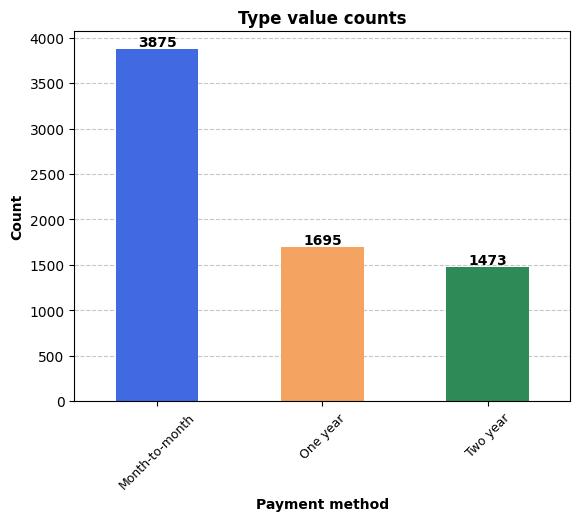

In [5]:
# Get value counts of Type field
print('TYPE value counts')
type_counts = contract['Type'].value_counts()
display(type_counts)

# Plot counts on a bar chart
type_counts.plot(kind='bar', color=['royalblue', 'sandybrown', 'seagreen'])

# Set title, axis labels, and tick information
plt.title('Type value counts', fontweight='bold')
plt.xlabel('Payment method', fontweight='bold')
plt.ylabel('Count', fontweight='bold')

xlabels = ['Month-to-month', 'One year', 'Two year']
xpositions = [0, 1, 2]
plt.xticks(xpositions, xlabels, fontsize=9, rotation=45)

for i in range(3):
    plt.text(i, type_counts[i], type_counts[i], ha='center', va='bottom', weight='bold')

# Add gridlines to chart
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().set_axisbelow(True)

# Display results
plt.show()

PAYMENTMETHOD value counts


Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

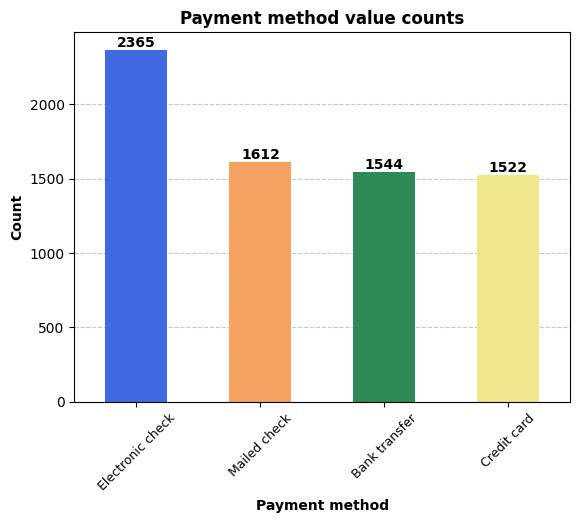

In [6]:
# Get value counts of PaymentMethod field
print('PAYMENTMETHOD value counts')
payment_method_counts = contract['PaymentMethod'].value_counts()
display(payment_method_counts)

# Plot counts on a bar chart
payment_method_counts.plot(kind='bar', color=['royalblue', 'sandybrown', 'seagreen', 'khaki'])

# Set title, axis labels, and tick information
plt.title('Payment method value counts', fontweight='bold')
plt.xlabel('Payment method', fontweight='bold')
plt.ylabel('Count', fontweight='bold')

xlabels = ['Electronic check', 'Mailed check', 'Bank transfer', 'Credit card']
xpositions = [0, 1, 2, 3]
plt.xticks(xpositions, xlabels, fontsize=9, rotation=45)

for i in range(4):
    plt.text(i, payment_method_counts[i], payment_method_counts[i], ha='center', va='bottom', weight='bold')

# Add gridlines to chart
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().set_axisbelow(True)

# Display results
plt.show()

BEGINDATE value counts


2014-02-01    366
2019-10-01    237
2019-09-01    237
2019-11-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-12-01      3
2013-10-01      3
2013-11-01      2
Name: BeginDate, Length: 77, dtype: int64

First date a client joined: 2013-10-01
Last date a client joined: 2020-02-01


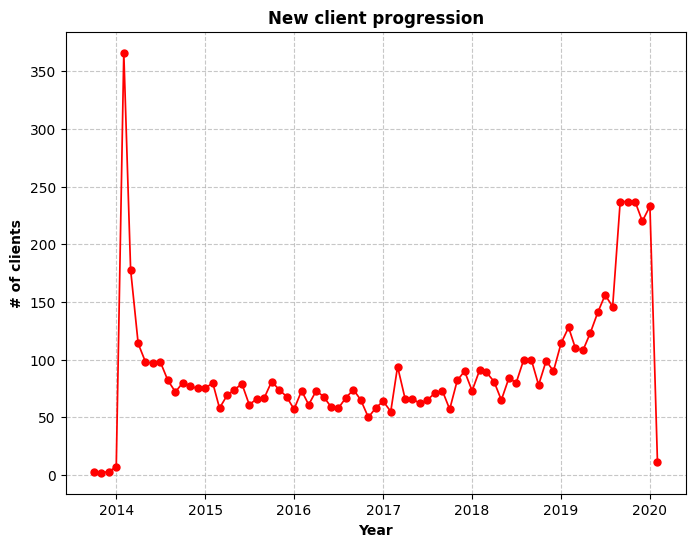

In [7]:
# Get value counts of BeginDate field
print('BEGINDATE value counts')
begin_date_counts = contract['BeginDate'].value_counts()
display(begin_date_counts)

# Get min and max values - time range of dataset
print('First date a client joined:', contract['BeginDate'].min())
print('Last date a client joined:', contract['BeginDate'].max())

# Reorganize value counts DataFrame
begin_date_counts = begin_date_counts.reset_index().rename(columns={'index': 'Date', 'BeginDate': 'Count'}).sort_values('Date').reset_index(drop=True)
begin_date_counts['Date'] = pd.to_datetime(begin_date_counts['Date'])

# Plot counts on a line chart
plt.figure(figsize=(8, 6))
plt.plot(begin_date_counts['Date'], begin_date_counts['Count'], color='red', marker='o', markersize=5, linewidth=1.25)

# Set title, axis labels, and tick information
plt.title('New client progression', fontweight='bold')
plt.xlabel('Year', fontweight='bold')
plt.ylabel('# of clients', fontweight='bold')

# Add gridlines to chart
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.gca().set_axisbelow(True)

# Display results
plt.show()

This graph displays how many new clients register with Interconnect a monthly basis throughout time. There is an big initial spike of 350 customers in the beginning of 2014. This could represent the influx of customers companies sometimes get when a company first begins business. After this initial spike, the number of new clients per month remains steady between 50 to 100 customers for about 3 to 4 years. In 2018, the number of new clients starts to increase, exceeding 100 customers per month. At the end of 2019, there is another abrupt spike of new customers, reaching almost 250 customers the last several months.

In [8]:
# Idenify unique values of the TotalCharges field
TotalCharges_unique = contract['TotalCharges'].unique()
display(np.sort(TotalCharges_unique))
print()
print('# of one space strings in the TotalCharges field:', contract[contract['TotalCharges'] == ' '].count()['TotalCharges'])

array([' ', '100.2', '100.25', ..., '999.45', '999.8', '999.9'],
      dtype=object)


# of one space strings in the TotalCharges field: 11


<b>Missing values</b>

In [9]:
# Identify missing values
display(contract.isna().sum())

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

<b>Duplicate values</b>

In [10]:
# Identify duplicate rows
print('# of duplicate rows:', contract.duplicated().sum())

# Identify duplicate customerIDs
print('# of duplicate customerIDs:', contract['customerID'].duplicated().sum())

# of duplicate rows: 0
# of duplicate customerIDs: 0


<b>Observations about the contract dataset</b>

In the contract dataset, there are 7043 records total. The dataset is imbalanced - over 73% of clients have not left the program. There are no missing values or duplicate values in the dataset.

Tasks for data preprocessing:

- Merge dataset with other datasets into one DataFrame via the <b><mark>customerID</mark></b> field
- Reformat column names to all lowercase lettering
- Convert <b><mark>BeginDate</mark></b> data type to datetime
- Replace one space string records in <b><mark>TotalCharges</mark></b> field with <b><mark>MonthlyCharges</mark></b> value
- Convert <b><mark>TotalCharges</mark></b> data type to float64

Tasks for feature engineering:

- Create a new boolean column (Yes / No) based on the <b><mark>EndDate</mark></b> field, indicating if the client has left or not
- Apply one-hot encoding for the <b><mark>PaymentMethod</mark></b>, <b><mark>Type</mark></b>, and <b><mark>PaperlessBilling</mark></b> fields
- Scale / standardize the <b><mark>MonthlyCharges</mark></b> and <b><mark>TotalCharges</mark></b> fields (feature scaling)
- Check for seasonality and trends in data by month
- Perform class imbalance fixing to target variable

### Internet dataset

<b>General summary</b>

In [11]:
# General summary of DataFrame
display(internet.info())
display(internet.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<b>Dataset contents and analysis</b>

INTERNETSERVICE value counts


Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

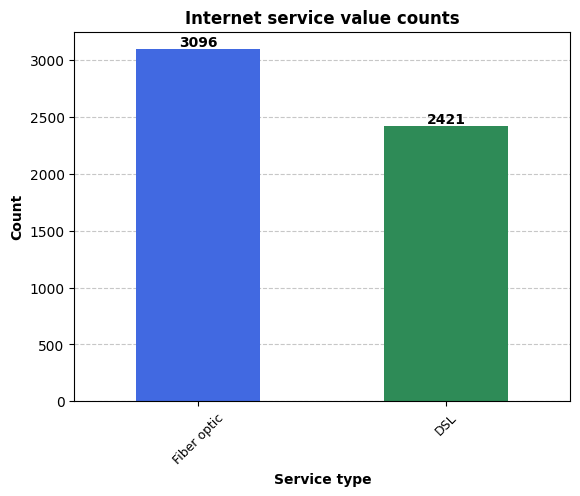

In [12]:
# Get value counts of InternetService field
print('INTERNETSERVICE value counts')
internet_service_counts = internet['InternetService'].value_counts()
display(internet_service_counts)

# Plot counts on a bar chart
internet_service_counts.plot(kind='bar', color=['royalblue', 'seagreen'])

# Set title, axis labels, and tick information
plt.title('Internet service value counts', fontweight='bold')
plt.xlabel('Service type', fontweight='bold')
plt.ylabel('Count', fontweight='bold')

xlabels = ['Fiber optic', 'DSL']
xpositions = [0, 1]
plt.xticks(xpositions, xlabels, fontsize=9, rotation=45)

for i in range(2):
    plt.text(i, internet_service_counts[i], internet_service_counts[i], ha='center', va='bottom', weight='bold')

# Add gridlines to chart
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().set_axisbelow(True)

# Display results
plt.show()

In [13]:
# Gather totals of each service that clients have
# Get DSL and FiberOptic totals for InternetService
DSL = 0
FO = 0

for i in internet['InternetService']:
    if i == 'DSL':
        DSL = DSL + 1
    else:
        FO = FO + 1

internet_list = [DSL, FO]

# Get totals for other services
columns = ['OnlineSecurity', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
other_services_list = []

for column in columns:
    total = internet[internet[column] == 'Yes'].count()[column]
    other_services_list.append(total)

# Combine both lists
total_list = internet_list + other_services_list

# Convert into a pandas DataFrame
service_names = ['DSL', 'FiberOptic', 'OnlineSecurity', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
services_df = pd.DataFrame({'servicetype': service_names, 'totalcustomers': total_list})

# Add percentage column
services_df['percentage'] = (round(services_df['totalcustomers'] / len(internet), 2) * 100).astype(int)

# Display DataFrame
print(services_df)
print()
print()
print('Internet service total:', DSL + FO)

        servicetype  totalcustomers  percentage
0               DSL            2421          44
1        FiberOptic            3096          56
2    OnlineSecurity            2019          37
3  DeviceProtection            2422          44
4       TechSupport            2044          37
5       StreamingTV            2707          49
6   StreamingMovies            2732          50


Internet service total: 5517


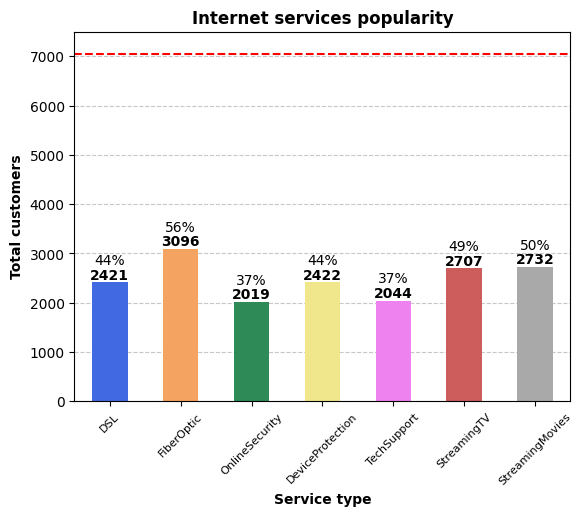

In [14]:
# Plot totals on a bar chart
services_df.plot(x='servicetype', y='totalcustomers', kind='bar', color=['royalblue', 'sandybrown', 'seagreen', 'khaki', 
                                                                         'violet', 'indianred', 'darkgray'], legend=False)

# Set title, axis labels and limits, and tick information
plt.title('Internet services popularity', fontweight='bold')
plt.xlabel('Service type', fontweight='bold')
plt.ylabel('Total customers', fontweight='bold')
plt.ylim(0, 7500)

xpositions = [0, 1, 2, 3, 4, 5, 6]
plt.xticks(xpositions, service_names, fontsize=8, rotation=45)

for i in range(7):
    plt.text(i, services_df['totalcustomers'][i], services_df['totalcustomers'][i], ha='center', va='bottom', weight='bold')
    plt.text(i, services_df['totalcustomers'][i] + 300, str(services_df['percentage'][i]) + '%', ha='center', va='bottom')

# Add horizontal line for total customers
total_customers = len(contract)
plt.axhline(y=total_customers, color='red', linestyle='--')

# Add gridlines to chart
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().set_axisbelow(True)

# Display results
plt.show()

In this chart, the different services that Interconnect offers, and customers pay for, are compared to examine their popularity. What services do most customers prefer? Most people today need the internet for daily activities, so it makes sense that almost <b>80%</b> of clients have either <mark>DSL</mark> or <mark>Fiber Optic</mark> internet, with <mark>Fiber Optic</mark> being the most popular because of its speed and reliability. TV services are also very popular today, as it seen and proven by the <mark>Streaming TV</mark> and <mark>Streaming Movies</mark> categories representing the second tier of most popular Interconnect services. <mark>Online Security</mark>, <mark>Device Protection</mark>, and <mark>Tech Support</mark> are the least used and least popular services by customers as these services can be viewed as "only when needed" and add-on type services. 

<b>Missing values</b>

In [15]:
# Identify missing values
display(internet.isna().sum())

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

<b>Duplicate values</b>

In [16]:
# Identify duplicate rows
print('# of duplicate rows:', internet.duplicated().sum())

# Identify duplicate customerIDs
print('# of duplicate customerIDs:', internet['customerID'].duplicated().sum())

# of duplicate rows: 0
# of duplicate customerIDs: 0


<b>Observations about the internet dataset</b>

In the internet dataset, there are 5517 records. This is ~1500 records / clients less than the entire dataset. This means after all the datasets are merged together, there will be missing values for the ~1500 records for the fields from the internet dataset. Missing values resulting from the merge will need to be filled in with a different value. There are no missing values or duplicate values in the dataset.

Tasks for data preprocessing:

- Merge dataset with other datasets into one DataFrame via the <b><mark>customerID</mark></b> field
- Fill in missing values with *Unknown* value after merge
- Reformat column names to all lowercase lettering

Tasks for feature engineering:

- Apply one-hot encoding for the <b><mark>InternetService</mark></b>, <b><mark>OnlineSecurity</mark></b>, <b><mark>OnlineBackup</mark></b>, <b><mark>DeviceProtection</mark></b>, <b><mark>TechSupport</mark></b>, <b><mark>StreamingTV</mark></b>, and <b><mark>StreamingMovies</mark></b> fields

### Personal dataset

<b>General summary</b>

In [17]:
# General summary of DataFrame
display(personal.info())
display(personal.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<b>Dataset contents and analysis</b>

GENDER value counts


Male      3555
Female    3488
Name: gender, dtype: int64

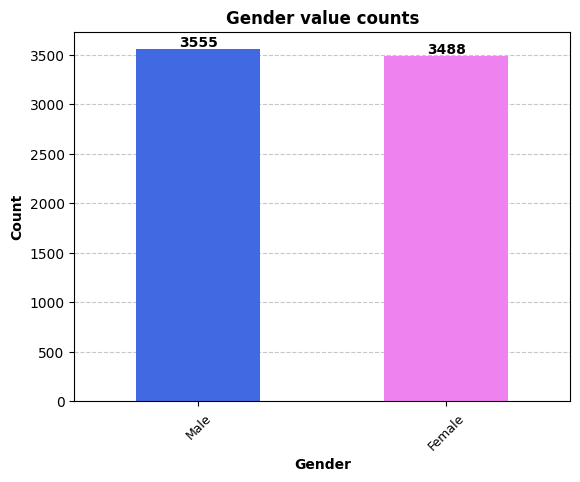

In [18]:
# Get value counts of Gender field
print('GENDER value counts')
gender_counts = personal['gender'].value_counts()
display(gender_counts)

# Plot counts on a bar chart
gender_counts.plot(kind='bar', color=['royalblue', 'violet'])

# Set title, axis labels, and tick information
plt.title('Gender value counts', fontweight='bold')
plt.xlabel('Gender', fontweight='bold')
plt.ylabel('Count', fontweight='bold')

xlabels = ['Male', 'Female']
xpositions = [0, 1]
plt.xticks(xpositions, xlabels, fontsize=9, rotation=45)

for i in range(2):
    plt.text(i, gender_counts[i], gender_counts[i], ha='center', va='bottom', weight='bold')

# Add gridlines to chart
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().set_axisbelow(True)

# Display results
plt.show()

In [19]:
# Get unique values for SeniorCitizen field
print(personal['SeniorCitizen'].unique())

[0 1]


<b>Missing values</b>

In [20]:
# Identify missing values
display(personal.isna().sum())

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

<b>Duplicate values</b>

In [21]:
# Identify duplicate rows
print('# of duplicate rows:', personal.duplicated().sum())

# Identify duplicate customerIDs
print('# of duplicate customerIDs:', personal['customerID'].duplicated().sum())

# of duplicate rows: 0
# of duplicate customerIDs: 0


<b>Observations about the personal dataset</b>

In the personal dataset, there are 7043 records which represents the whole dataset. There are no missing values or duplicate values in the dataset.

Tasks for data preprocessing:

- Merge dataset with other datasets into one DataFrame via the <b><mark>customerID</mark></b> field
- Reformat column names to all lowercase lettering

Tasks for feature engineering:

- Apply one-hot encoding for the <b><mark>Gender</mark></b>, <b><mark>Partner</mark></b>, and <b><mark>Dependents</mark></b> fields
    - The <b><mark>SeniorCitizen</mark></b> field is already in a numerical format, so it does not require encoding

### Phone dataset

<b>General summary</b>

In [22]:
# General summary of DataFrame
display(phone.info())
display(phone.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<b>Missing values</b>

In [23]:
# Identify missing values
display(phone.isna().sum())

customerID       0
MultipleLines    0
dtype: int64

<b>Duplicate values</b>

In [24]:
# Identify duplicate rows
print('# of duplicate rows:', phone.duplicated().sum())

# Identify duplicate customerIDs
print('# of duplicate customerIDs:', phone['customerID'].duplicated().sum())

# of duplicate rows: 0
# of duplicate customerIDs: 0


<b>Observations about the phone dataset</b>

In the internet dataset, there are 6361 records. This is ~700 records / clients less than the entire dataset. As for the internet dataste, this means after all the datasets are merged together, there will be missing values for the ~700 records for the fields from the phone dataset. Missing values resulting from the merge will need to be filled in with a different value. There are no missing values or duplicate values in the dataset.

Tasks for data preprocessing:

- Merge dataset with other datasets into one DataFrame via the <b><mark>customerID</mark></b> field
- Fill in missing values with *Unknown* value after merge
- Reformat column names to all lowercase lettering

Tasks for feature engineering:

- Apply one-hot encoding for the <b><mark>MultipleLines</mark></b> field

# Project work plan

Can machine learning assist Interconnect in forecasting future client churn and predicting which customers are expected to leave its services? The goal of the project is to develop a model that can accurately classify if a client will leave the services of Interconnect or not. After analyzing the data, here are the detailed steps to achieve this.

<b>Introduction</b>
1. Load libraries and modules needed for analysis and modeling
</br></br>
2. Download the four datasets into pandas DataFrames
</br></br>
3. Explore each dataset to determine data preprocessing tasks, feature engineering tasks, and model building details
</br>

<b>Project work plan</b></br>

1. Perform data preprocessing tasks</br>
    - Merge the four datasets into one main DataFrame
        - Fill in missing values resulting from the merge
    - Update columns names to all lowercase lettering
    - Replace values for one space string records in <b><mark>TotalCharges</mark></b> field
    - Convert the data types of certain columns
</br></br>
2. Perform EDA to explore data in depth and identify patterns and relationships</br>
    - Client churn progression
    - Client tenure distribution
    - Client characteristics and churn
        - Gender
        - Senior citizen
    - Internet services comparison
    - Contract length comparison
    - Monthly and total charges comparison
</br></br>
3. Perform feature engineering tasks</br>
    - Create a new Yes / No column from the <b><mark>EndDate</mark></b> field. This field represents the target variable
    - Apply one-hot encoding to categorical features
    - Apply feature scaling / standardization to numerical features
    - Perform upsampling to target variable to mitigate the class imbalance in the dataset
</br></br>
4. Conduct model preparation</br>
    - Define features and target
    - Split data into training, validation, and test datasets
    - Create function for building and evaluating the models
    - Create a Logistic Regression dummy model for comparison and basic evaluation
</br></br>
5. Train, build, and fine-tune 3 classification models</br>
    - Model types:
        - Random forest
        - K-nearest neighbor
        - Gradient boosting
    - Model building tasks:
        - Fine-tine model parameters
        - Apply bootstrapping / bagging technique
        - Retrieve AUC-ROC and accuracy scores to evaluate model
        - Compare the final metrics to the base model</br></br>
6. Final model evaluation</br>

<b>Conclusions</b>